# SensCritique Project

This project, available on [GitHub](https://github.com/fengyu20/movie_popularity_prediction), contains three main components:
1. **Web Scraping**: Extraction of data from web pages, including titles, directors, ratings, publication years, etc.
2. **Data Cleaning**: Enhancement of data quality and structure, as well as preparation of categorical data for machine learning applications.
3. **Prediction Model**: Implementation of Random Forest and XGBoost algorithms to predict movie ratings, with Grid Search employed to optimize model parameters.

**Reference Materials:**
1. [Udacity Data Analyst Nanodegree Flight Delay Forecast Project](https://github.com/fengyu20/udacity_data_analyst_nanodegree_projects/blob/master/CN_flight_delay_forecast_master/FlightDelayForecast.ipynb): A past project that provided insights on data cleaning and machine learning techniques.
2. [Movie Popularity Prediction Full Project on Kaggle](https://www.kaggle.com/code/huntermitchell/movie-popularity-prediction-full-project/notebook): This resource informed my feature selection and helped structure the code effectively.
3. Online materials: As I was navigating unfamiliar subject with Beautifulsoup and Selenium, I used ChatGPT, official documentation, and Stackoverflow to complete the web driver segment.

Additionally, I have created [a basic tutorial](https://www.notion.so/fengyu23/SensCritique-Project-Basic-Tutorial-756d6801d0664c7eb71e95ab383848a7#d9ddea4ecb5249b5a413f5867d78f713) aimed at assisting classmates with understanding and completing the assignment. This tutorial is designed to guide without providing direct code solutions.

In [1]:
pip install unidecode scikit-learn BeautifulSoup4 pandas requests lxml selenium regex xgboost seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
import re
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import xgboost as xgb
from bs4 import BeautifulSoup
from selenium import webdriver
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder


##  1. Get the film data from the website

The reasons why I chose the following features:
1. It's easy to manage numerical and categorical values for future predictions.
2. After going through several online projects regarding movie predictions, I found the most commonly used features from IMDb datasets to be `languages`, `budgets`, `genres`, `runtime`, `vote_average`, `vote_count`.
3. After checking the SensCritique website, I found features that might be useful for prediction. 
   1. The chosen features:
      1. Numerical: `ranking`, `year`, `duration`, `stars`, `favorites`, `saves`, `number of critiques`.
      2. Categorical: `director`, `genres`, `group`, `country of origin (pays d'origine)`.
      3. Other: `original_title` could be used to create a linked table with information from IMDb datasets.
   2. The features that I did not choose:
      1. `Synopsis`: Requires further NLP (Natural Language Processing) analysis, which could make it challenging to process and find a link to the ranking.

In [3]:
search_dict_main_page = {
    'rating': {'name': 'div', 'attrs': {"data-testid": "Rating"}},
    'director': {'name': 'a', 'attrs': {"data-testid": "link"}},
    'duration': {'name': 'span', 'attrs': {"data-testid": "duration"}},
    'genres': {'name': 'span', 'attrs': {"data-testid": "genres"}},
    'ranking': {'name': 'span', 'attrs':{'data-testid': 'product-title-wrapper'}}
}

search_dict_film_page = {
    'film_year': {'name': 'p', 'attrs': {"class": "Text__SCTitle-sc-1aoldkr-1 CoverProductInfos__StyledText-sc-1un0kh1-13 eGhlHy jugtWW"}},
    'original_title':{'name': 'p', 'attrs': {"class": "Text__SCTitle-sc-1aoldkr-1 CoverProductInfos__StyledText-sc-1un0kh1-13 eGhlHy kuMSsq"}}
}


In [4]:
class RequestSensCritique:
    def __init__(self):
        self._base_urls = 'https://www.senscritique.com/'
    
    def create_soup(self, content, is_url=True):
        if is_url:
            page_content = requests.get(content).content
        else:
            page_content = content
        
        return BeautifulSoup(page_content, "html.parser")

    def find_text(self, element, search_criteria):
        found_element = element.find(**search_criteria)
        return found_element.text if found_element else None

    def get_full_page(self, link):
        full_url = self._base_urls + link
        driver = webdriver.Chrome()

        try:
            driver.get(full_url)

            for _ in range(8):
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(2)
            
            page_source = driver.page_source

        finally:
            driver.quit()

        return self.create_soup(page_source, is_url=False)
        
    def get_film_page_info(self, film_link, dict_name):
        film_url = self._base_urls + film_link
        film_page_soup = self.create_soup(film_url)

        film_page_dict = {key: self.find_text(film_page_soup, criteria) for key, criteria in dict_name.items()}

        stats_elements = film_page_soup.select('p.Text__SCText-sc-1aoldkr-0.Stats__Text-sc-1u6v943-2.gATBvI')
        if len(stats_elements) == 3:
            film_page_dict['stars'] = stats_elements[0].text
            film_page_dict['saves'] = stats_elements[1].text
            film_page_dict['favorites'] = stats_elements[2].text
        
        critique_number_text = film_page_soup.select('.NavigationTab__WrapperTextStyled-sc-18dtd9d-7')[2].text
        film_page_dict['critique_number'] = int(critique_number_text.split('(')[-1].split(')')[0])

        # certain movies do not have film_group and origin_country
        group_label = film_page_soup.find('span', string='Groupe : ')
        if group_label:
            film_page_dict['film_group'] = group_label.find_next('a', {'class': 'Text__SCText-sc-1aoldkr-0 Link__PrimaryLink-sc-1v081j9-0 gATBvI bGxijB'}).text

        country_label = film_page_soup.find('h3', string=re.compile('Pays d\'origine :'))
        if country_label:
            film_page_dict['origin_country'] = country_label.find_next_sibling('span').get_text()
        
        return film_page_dict
    
    def get_main_page(self, link, main_dict, film_info_dict):
        film_soup = self.get_full_page(link)

        films = film_soup.find_all('div', class_="ProductListItem__Wrapper-sc-1jkxxpj-1 kusRkg")

        all_films_dict = {}

        for film in films:
            title = self.find_text(film, {'name': 'a', 'attrs': {"data-testid": "product-title"}})

            new_film_dict = {key: self.find_text(film, criteria) for key, criteria in main_dict.items()}

            film_link = film.find('a', {"data-testid": "product-title"})['href']
            new_film_dict.update(self.get_film_page_info(film_link, film_info_dict))
            
            all_films_dict[title] = new_film_dict
        
        return all_films_dict


In [5]:
create_request = RequestSensCritique()

top_111_link = 'films/tops/top111'
films_info_dict = create_request.get_main_page(top_111_link, search_dict_main_page,search_dict_film_page )

In [6]:
# save the data to the json file
import os
os.makedirs('data', exist_ok=True)

with open('data/film_info.json', 'w') as json_file:
    json.dump(films_info_dict, json_file, indent=4)

## 2. Read and Clean the data

### 2.1 Getting to know the data

In [7]:
df = pd.read_json('data/film_info.json', orient='index')

df.head()

,rating,director,duration,genres,ranking,film_year,original_title,stars,saves,favorites,critique_number,film_group,origin_country
Douze Hommes en colère (1957),8.7,Sidney Lumet,1 h 36 min.,"Policier, Drame",1. Douze Hommes en colère (1957),1957,12 Angry Men,51.8K,16.4K,6.8K,592,Douze hommes en colère,États-Unis
Harakiri (1962),8.6,Masaki Kobayashi,2 h 13 min.,Drame,2. Harakiri (1962),1962,Seppuku,8.2K,12.7K,1.5K,115,Hara-Kiri,Japon
Blade Runner : The Final Cut (2007),8.5,Ridley Scott,1 h 57 min.,Science-fiction,3. Blade Runner : The Final Cut (2007),2007,None,1.2K,275,111,4,Blade Runner,NaN
"Le Bon, la Brute et le Truand (1966)",8.5,Sergio Leone,2 h 59 min.,"Western, Aventure","4. Le Bon, la Brute et le Truand (1966)",1966,"Il buono, il brutto, il cattivo",54.5K,13.6K,5.5K,379,La Trilogie du dollar,"Italie,"
Barberousse (1965),8.5,Akira Kurosawa,3 h 05 min.,Drame,5. Barberousse (1965),1965,Akahige,4.3K,7.7K,834,88,Barberousse,Japon


In [56]:
# add the data validation to check the number of movies
assert len(df) == 111

In [8]:
df.sample(5,random_state=2000)

,rating,director,duration,genres,ranking,film_year,original_title,stars,saves,favorites,critique_number,film_group,origin_country
Psychose (1960),8.3,Alfred Hitchcock,1 h 49 min.,Thriller,26. Psychose (1960),1960,Psycho,51.8K,12.4K,3.7K,344,Psychose,États-Unis
Vivre (1952),8.1,Akira Kurosawa,2 h 23 min.,Drame,77. Vivre (1952),1952,Ikiru,2.5K,4.2K,423,45,Vivre,Japon
Gentleman Jim (1942),8.1,Raoul Walsh,1 h 44 min.,"Biopic, Sport, Romance",70. Gentleman Jim (1942),1942,None,1.1K,2K,224,36,NaN,États-Unis
Shoah (1985),8.0,Claude Lanzmann,9 h 26 min.,"Historique, Guerre",108. Shoah (1985),1985,None,2.3K,3.4K,138,26,NaN,"France,"
Sherlock Junior (1924),8.3,Buster Keaton,45 min.,"Muet, Comédie, Action",18. Sherlock Junior (1924),1924,Sherlock Jr.,3.7K,3.3K,577,43,NaN,États-Unis


Noticed Problems from the sample:
1. The first column should be named as `title`, and we should delete the year from the title.
2. `duration` should be converted to `int` for future analysis. For example, `1 h 36 min.` should be converted to `96`.
3. `genres` should use the `exploded` function to save them to separate rows.
4. `stars`, `saves`, and `favorites` should be converted to numerical values.

Check the categorical data.

In [9]:
df['origin_country'].value_counts()

origin_country
États-Unis          45
Japon               14
États-Unis,          8
France               8
France,              5
Allemagne            4
Italie,              4
Union Soviétique     4
Royaume-Uni          3
Royaume-Uni,         3
Corée du Sud         3
Suède                2
Danemark             2
Japon,               2
Suisse,              1
Hongrie,             1
Cuba,                1
Name: count, dtype: int64

We need to delete the commas in the column of `origin_country`.

In [10]:
df['director'].value_counts()

director
Akira Kurosawa      6
Fritz Lang          4
Charlie Chaplin     4
Sidney Lumet        3
Sergio Leone        3
                   ..
Charles Laughton    1
Irvin Kershner      1
Park Chan-Wook      1
Béla Tarr           1
Werner Herzog       1
Name: count, Length: 69, dtype: int64

In [11]:
df['genres'].value_counts()

genres
Drame                           17
Drame, Guerre                    6
Policier, Drame, Thriller        5
Historique, Guerre               3
Drame, Thriller                  3
                                ..
Muet, Drame, Science-fiction     1
Drame, Historique, Aventure      1
Drame, Science-fiction           1
Cinéma                           1
Drame, Policier                  1
Name: count, Length: 66, dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111 entries, Douze Hommes en colère (1957) to Leçons de ténèbres (1992)
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rating           111 non-null    float64
 1   director         111 non-null    object 
 2   duration         111 non-null    object 
 3   genres           109 non-null    object 
 4   ranking          111 non-null    object 
 5   film_year        111 non-null    int64  
 6   original_title   84 non-null     object 
 7   stars            111 non-null    object 
 8   saves            111 non-null    object 
 9   favorites        111 non-null    object 
 10  critique_number  111 non-null    int64  
 11  film_group       58 non-null     object 
 12  origin_country   110 non-null    object 
dtypes: float64(1), int64(2), object(10)
memory usage: 12.1+ KB


Summaries from the info:
1. There are two films that don't have `genres`, check the website to validate the correctness. -> They don't have genres on the website as well.
2. `film_group` has lots of empty data, so I won't use it to do the prediction.

In [13]:
empty_genres = df[df['genres'].isna()]

empty_genres.head()

,rating,director,duration,genres,ranking,film_year,original_title,stars,saves,favorites,critique_number,film_group,origin_country
Le Joli Mai (1963),8.1,Chris Marker,2 h 16 min.,None,75. Le Joli Mai (1963),1963,None,1.6K,2.2K,242,27,NaN,France
Paris Is Burning (1991),8.1,Jennie Livingston,1 h 11 min.,None,84. Paris Is Burning (1991),1991,None,2.1K,2.2K,302,10,NaN,États-Unis


In [14]:
df['rating'].describe()

count    111.000000
mean       8.169369
std        0.152430
min        8.000000
25%        8.100000
50%        8.100000
75%        8.200000
max        8.700000
Name: rating, dtype: float64

### 2.2 Clean the Data
Based on what I've observed from the sample data.

In [15]:
# name the first column to title
df.reset_index(inplace=True)

df.rename(columns={'index': 'title'}, inplace=True)


In [16]:
# clean the title without the year
def clean_title(title):
    return re.sub(r' \(\d{4}\)', '', title)
  
df['clean_title'] = df['title'].apply(clean_title)

df.head()


,title,rating,director,duration,genres,ranking,film_year,original_title,stars,saves,favorites,critique_number,film_group,origin_country,clean_title
0,Douze Hommes en colère (1957),8.7,Sidney Lumet,1 h 36 min.,"Policier, Drame",1. Douze Hommes en colère (1957),1957,12 Angry Men,51.8K,16.4K,6.8K,592,Douze hommes en colère,États-Unis,Douze Hommes en colère
1,Harakiri (1962),8.6,Masaki Kobayashi,2 h 13 min.,Drame,2. Harakiri (1962),1962,Seppuku,8.2K,12.7K,1.5K,115,Hara-Kiri,Japon,Harakiri
2,Blade Runner : The Final Cut (2007),8.5,Ridley Scott,1 h 57 min.,Science-fiction,3. Blade Runner : The Final Cut (2007),2007,None,1.2K,275,111,4,Blade Runner,NaN,Blade Runner : The Final Cut
3,"Le Bon, la Brute et le Truand (1966)",8.5,Sergio Leone,2 h 59 min.,"Western, Aventure","4. Le Bon, la Brute et le Truand (1966)",1966,"Il buono, il brutto, il cattivo",54.5K,13.6K,5.5K,379,La Trilogie du dollar,"Italie,","Le Bon, la Brute et le Truand"
4,Barberousse (1965),8.5,Akira Kurosawa,3 h 05 min.,Drame,5. Barberousse (1965),1965,Akahige,4.3K,7.7K,834,88,Barberousse,Japon,Barberousse


In [17]:
# convert duration to numerique values
def convert_to_minutes(duration_str):
    parts = duration_str.split()
    hours = int(parts[0])
    minutes = int(parts[-2])
    total_minutes = hours * 60 + minutes

    return total_minutes

df['duration_minutes'] = df['duration'].apply(convert_to_minutes)

df.head(5)

,title,rating,director,duration,genres,ranking,film_year,original_title,stars,saves,favorites,critique_number,film_group,origin_country,clean_title,duration_minutes
0,Douze Hommes en colère (1957),8.7,Sidney Lumet,1 h 36 min.,"Policier, Drame",1. Douze Hommes en colère (1957),1957,12 Angry Men,51.8K,16.4K,6.8K,592,Douze hommes en colère,États-Unis,Douze Hommes en colère,96
1,Harakiri (1962),8.6,Masaki Kobayashi,2 h 13 min.,Drame,2. Harakiri (1962),1962,Seppuku,8.2K,12.7K,1.5K,115,Hara-Kiri,Japon,Harakiri,133
2,Blade Runner : The Final Cut (2007),8.5,Ridley Scott,1 h 57 min.,Science-fiction,3. Blade Runner : The Final Cut (2007),2007,None,1.2K,275,111,4,Blade Runner,NaN,Blade Runner : The Final Cut,117
3,"Le Bon, la Brute et le Truand (1966)",8.5,Sergio Leone,2 h 59 min.,"Western, Aventure","4. Le Bon, la Brute et le Truand (1966)",1966,"Il buono, il brutto, il cattivo",54.5K,13.6K,5.5K,379,La Trilogie du dollar,"Italie,","Le Bon, la Brute et le Truand",179
4,Barberousse (1965),8.5,Akira Kurosawa,3 h 05 min.,Drame,5. Barberousse (1965),1965,Akahige,4.3K,7.7K,834,88,Barberousse,Japon,Barberousse,185


In [18]:
# get ranking number from ranking column
df['ranking_number'] = df['ranking'].str.split('.').str.get(0)

df.head(5)

,title,rating,director,duration,genres,ranking,film_year,original_title,stars,saves,favorites,critique_number,film_group,origin_country,clean_title,duration_minutes,ranking_number
0,Douze Hommes en colère (1957),8.7,Sidney Lumet,1 h 36 min.,"Policier, Drame",1. Douze Hommes en colère (1957),1957,12 Angry Men,51.8K,16.4K,6.8K,592,Douze hommes en colère,États-Unis,Douze Hommes en colère,96,1
1,Harakiri (1962),8.6,Masaki Kobayashi,2 h 13 min.,Drame,2. Harakiri (1962),1962,Seppuku,8.2K,12.7K,1.5K,115,Hara-Kiri,Japon,Harakiri,133,2
2,Blade Runner : The Final Cut (2007),8.5,Ridley Scott,1 h 57 min.,Science-fiction,3. Blade Runner : The Final Cut (2007),2007,None,1.2K,275,111,4,Blade Runner,NaN,Blade Runner : The Final Cut,117,3
3,"Le Bon, la Brute et le Truand (1966)",8.5,Sergio Leone,2 h 59 min.,"Western, Aventure","4. Le Bon, la Brute et le Truand (1966)",1966,"Il buono, il brutto, il cattivo",54.5K,13.6K,5.5K,379,La Trilogie du dollar,"Italie,","Le Bon, la Brute et le Truand",179,4
4,Barberousse (1965),8.5,Akira Kurosawa,3 h 05 min.,Drame,5. Barberousse (1965),1965,Akahige,4.3K,7.7K,834,88,Barberousse,Japon,Barberousse,185,5


In [19]:
# delete the commas in the column of `origin_country`.
df['origin_country_clean'] = df['origin_country'].str.replace(',', ' ')

# clean the extra space here
df['origin_country_clean'] = df['origin_country_clean'].str.strip()

df['origin_country_clean'].value_counts()


origin_country_clean
États-Unis          53
Japon               16
France              13
Royaume-Uni          6
Italie               4
Union Soviétique     4
Allemagne            4
Corée du Sud         3
Suède                2
Danemark             2
Cuba                 1
Hongrie              1
Suisse               1
Name: count, dtype: int64

In [20]:
# convert stars, saves favorites to numbers
def deal_with_k(number_str):
    if 'K' in number_str:
        parts = number_str.split('K')[0]
        return int(float(parts) * 1000)
    else:
        return int(number_str)

df['stars_number'] = df['stars'].apply(deal_with_k)
df['saves_number'] = df['saves'].apply(deal_with_k)
df['favorites_number'] = df['favorites'].apply(deal_with_k)

df.head(5)


,title,rating,director,duration,genres,ranking,film_year,original_title,stars,saves,...,critique_number,film_group,origin_country,clean_title,duration_minutes,ranking_number,origin_country_clean,stars_number,saves_number,favorites_number
0,Douze Hommes en colère (1957),8.7,Sidney Lumet,1 h 36 min.,"Policier, Drame",1. Douze Hommes en colère (1957),1957,12 Angry Men,51.8K,16.4K,...,592,Douze hommes en colère,États-Unis,Douze Hommes en colère,96,1,États-Unis,51800,16400,6800
1,Harakiri (1962),8.6,Masaki Kobayashi,2 h 13 min.,Drame,2. Harakiri (1962),1962,Seppuku,8.2K,12.7K,...,115,Hara-Kiri,Japon,Harakiri,133,2,Japon,8200,12700,1500
2,Blade Runner : The Final Cut (2007),8.5,Ridley Scott,1 h 57 min.,Science-fiction,3. Blade Runner : The Final Cut (2007),2007,None,1.2K,275,...,4,Blade Runner,NaN,Blade Runner : The Final Cut,117,3,NaN,1200,275,111
3,"Le Bon, la Brute et le Truand (1966)",8.5,Sergio Leone,2 h 59 min.,"Western, Aventure","4. Le Bon, la Brute et le Truand (1966)",1966,"Il buono, il brutto, il cattivo",54.5K,13.6K,...,379,La Trilogie du dollar,"Italie,","Le Bon, la Brute et le Truand",179,4,Italie,54500,13600,5500
4,Barberousse (1965),8.5,Akira Kurosawa,3 h 05 min.,Drame,5. Barberousse (1965),1965,Akahige,4.3K,7.7K,...,88,Barberousse,Japon,Barberousse,185,5,Japon,4300,7700,834


In [21]:
# process genres, prepared it for one hot encoding
df['genres_split'] = df['genres'].str.split(', ')

df.head()

,title,rating,director,duration,genres,ranking,film_year,original_title,stars,saves,...,film_group,origin_country,clean_title,duration_minutes,ranking_number,origin_country_clean,stars_number,saves_number,favorites_number,genres_split
0,Douze Hommes en colère (1957),8.7,Sidney Lumet,1 h 36 min.,"Policier, Drame",1. Douze Hommes en colère (1957),1957,12 Angry Men,51.8K,16.4K,...,Douze hommes en colère,États-Unis,Douze Hommes en colère,96,1,États-Unis,51800,16400,6800,"[Policier, Drame]"
1,Harakiri (1962),8.6,Masaki Kobayashi,2 h 13 min.,Drame,2. Harakiri (1962),1962,Seppuku,8.2K,12.7K,...,Hara-Kiri,Japon,Harakiri,133,2,Japon,8200,12700,1500,[Drame]
2,Blade Runner : The Final Cut (2007),8.5,Ridley Scott,1 h 57 min.,Science-fiction,3. Blade Runner : The Final Cut (2007),2007,None,1.2K,275,...,Blade Runner,NaN,Blade Runner : The Final Cut,117,3,NaN,1200,275,111,[Science-fiction]
3,"Le Bon, la Brute et le Truand (1966)",8.5,Sergio Leone,2 h 59 min.,"Western, Aventure","4. Le Bon, la Brute et le Truand (1966)",1966,"Il buono, il brutto, il cattivo",54.5K,13.6K,...,La Trilogie du dollar,"Italie,","Le Bon, la Brute et le Truand",179,4,Italie,54500,13600,5500,"[Western, Aventure]"
4,Barberousse (1965),8.5,Akira Kurosawa,3 h 05 min.,Drame,5. Barberousse (1965),1965,Akahige,4.3K,7.7K,...,Barberousse,Japon,Barberousse,185,5,Japon,4300,7700,834,[Drame]


## 3. The Movie Popularity Prediction 

### 3.1 Prepare the dataframes for prediction

The reason I selected these features is to analyze the ratings and rankings on this website more effectively. These may be influenced by preferences towards specific directors or countries. 

Additionally, by examining these features, we might uncover relationships between the ratings and various factors such as the number of stars, saves, favorites, and critiques.

In [22]:
features_temp_df = df[['clean_title','director','origin_country_clean', 'genres_split', 'duration_minutes','stars_number','saves_number','favorites_number','critique_number','film_year']]

labels_df = df[['ranking_number', 'rating']]

ranking_df = labels_df['ranking_number']
rating_df = labels_df['rating']

#### 3.1.1 Deal with numerique datas

Have a look at the dataset and drop values that would be outliers.

In [23]:
features_temp_df.head()

,clean_title,director,origin_country_clean,genres_split,duration_minutes,stars_number,saves_number,favorites_number,critique_number,film_year
0,Douze Hommes en colère,Sidney Lumet,États-Unis,"[Policier, Drame]",96,51800,16400,6800,592,1957
1,Harakiri,Masaki Kobayashi,Japon,[Drame],133,8200,12700,1500,115,1962
2,Blade Runner : The Final Cut,Ridley Scott,NaN,[Science-fiction],117,1200,275,111,4,2007
3,"Le Bon, la Brute et le Truand",Sergio Leone,Italie,"[Western, Aventure]",179,54500,13600,5500,379,1966
4,Barberousse,Akira Kurosawa,Japon,[Drame],185,4300,7700,834,88,1965


In [24]:
features_temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   clean_title           111 non-null    object
 1   director              111 non-null    object
 2   origin_country_clean  110 non-null    object
 3   genres_split          109 non-null    object
 4   duration_minutes      111 non-null    int64 
 5   stars_number          111 non-null    int64 
 6   saves_number          111 non-null    int64 
 7   favorites_number      111 non-null    int64 
 8   critique_number       111 non-null    int64 
 9   film_year             111 non-null    int64 
dtypes: int64(6), object(4)
memory usage: 8.8+ KB


In [25]:
features_temp_df.describe()

,duration_minutes,stars_number,saves_number,favorites_number,critique_number,film_year
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,238.423423,26065.981982,7991.666667,2245.972973,177.162162,1967.603604
std,509.831836,40858.882891,5441.881290,2839.994873,188.976119,24.301620
min,64.000000,875.000000,275.000000,91.000000,4.000000,1921.000000
25%,108.000000,2400.000000,3850.000000,362.000000,41.000000,1953.000000
50%,130.000000,7700.000000,6500.000000,1000.000000,97.000000,1965.000000
75%,173.000000,35500.000000,11250.000000,2900.000000,252.000000,1985.000000
max,3294.000000,246800.000000,27700.000000,14100.000000,920.000000,2019.000000


In [26]:
features_temp_df.isnull().any()

clean_title             False
director                False
origin_country_clean     True
genres_split             True
duration_minutes        False
stars_number            False
saves_number            False
favorites_number        False
critique_number         False
film_year               False
dtype: bool

#### 3.1.2 Deal with categorical data / Feature Engineering

In [27]:
# check if we have empty values in the categorical data
features_temp_df.isnull().any()

# create a copy of it
features_temp_df = features_temp_df.copy()

features_temp_df[features_temp_df.isnull().values==True]


,clean_title,director,origin_country_clean,genres_split,duration_minutes,stars_number,saves_number,favorites_number,critique_number,film_year
2,Blade Runner : The Final Cut,Ridley Scott,NaN,[Science-fiction],117,1200,275,111,4,2007
74,Le Joli Mai,Chris Marker,France,None,136,1600,2200,242,27,1963
83,Paris Is Burning,Jennie Livingston,États-Unis,None,71,2100,2200,302,10,1991


In [28]:
# fillna instead of dropna, as we need to have the same amout of data in features_df and labels_df
features_temp_df['origin_country_clean'].fillna("empty", inplace = True)
features_temp_df['genres_split'].fillna("empty", inplace = True)


In [29]:
features_temp_df[features_temp_df.isnull().values==True]

,clean_title,director,origin_country_clean,genres_split,duration_minutes,stars_number,saves_number,favorites_number,critique_number,film_year


In [30]:
label_encoder = LabelEncoder()

feature_director_df = features_temp_df.copy()

feature_director_df['director_encoded'] = label_encoder.fit_transform(feature_director_df['director'])

feature_director_final_df = feature_director_df.copy()

feature_director_final_df.drop(columns = ["director","clean_title","origin_country_clean", 'genres_split'], inplace=True)

feature_director_final_df.head()



,duration_minutes,stars_number,saves_number,favorites_number,critique_number,film_year,director_encoded
0,96,51800,16400,6800,592,1957,60
1,133,8200,12700,1500,115,1962,47
2,117,1200,275,111,4,2007,57
3,179,54500,13600,5500,379,1966,58
4,185,4300,7700,834,88,1965,0


In [31]:
exploded_df = feature_director_df.explode('genres_split')

one_hot_encoded_df = pd.get_dummies(exploded_df, columns=['genres_split'], prefix='', prefix_sep='')

# avoid summing up other numeric values here
features_genres_df = one_hot_encoded_df.groupby('clean_title').max().reset_index()

features_genres_df.head()


,clean_title,director,origin_country_clean,duration_minutes,stars_number,saves_number,favorites_number,critique_number,film_year,director_encoded,...,Musique,Policier,Romance,Science-fiction,Société,Sport,Thriller,Western,empty,Épouvante-Horreur
0,12 hommes en colère,William Friedkin,États-Unis,117,2000,2300,91,12,1997,68,...,False,True,False,False,False,False,False,False,False,False
1,Alien - Le 8ème Passager,Ridley Scott,États-Unis,117,64099,7000,5500,519,1979,57,...,False,False,False,True,False,False,False,False,False,True
2,Andreï Roublev,Andreï Tarkovski,Union Soviétique,183,4200,6400,552,73,1966,3,...,False,False,False,False,False,False,False,False,False,False
3,Apocalypse Now,Francis Ford Coppola,États-Unis,147,55600,20900,4800,378,1979,23,...,False,False,False,False,False,False,False,False,False,False
4,Autopsie d'un meurtre,Otto Preminger,États-Unis,160,3800,4400,409,74,1959,52,...,False,True,False,False,False,False,True,False,False,False


In [32]:
# randonmly pick the value and check the correctness
assert features_genres_df[features_genres_df["clean_title"] == "Andreï Roublev"]["saves_number"].values[0] == features_temp_df[features_temp_df["clean_title"] == "Andreï Roublev"]["saves_number"].values[0]

In [33]:
one_hot_encoded_country_df = pd.get_dummies(features_genres_df, columns=['origin_country_clean'], prefix='', prefix_sep='')

# avoid summing up other numeric values here
features_countries_df = one_hot_encoded_df.groupby('clean_title').max().reset_index()

features_countries_df.head()


,clean_title,director,origin_country_clean,duration_minutes,stars_number,saves_number,favorites_number,critique_number,film_year,director_encoded,...,Musique,Policier,Romance,Science-fiction,Société,Sport,Thriller,Western,empty,Épouvante-Horreur
0,12 hommes en colère,William Friedkin,États-Unis,117,2000,2300,91,12,1997,68,...,False,True,False,False,False,False,False,False,False,False
1,Alien - Le 8ème Passager,Ridley Scott,États-Unis,117,64099,7000,5500,519,1979,57,...,False,False,False,True,False,False,False,False,False,True
2,Andreï Roublev,Andreï Tarkovski,Union Soviétique,183,4200,6400,552,73,1966,3,...,False,False,False,False,False,False,False,False,False,False
3,Apocalypse Now,Francis Ford Coppola,États-Unis,147,55600,20900,4800,378,1979,23,...,False,False,False,False,False,False,False,False,False,False
4,Autopsie d'un meurtre,Otto Preminger,États-Unis,160,3800,4400,409,74,1959,52,...,False,True,False,False,False,False,True,False,False,False


In [34]:
# randonmly pick the value and check the correctness
assert features_countries_df[features_countries_df["clean_title"] == "Andreï Roublev"]["saves_number"].values[0] == features_temp_df[features_temp_df["clean_title"] == "Andreï Roublev"]["saves_number"].values[0]

In [35]:
features_final_df = features_countries_df.copy()

features_final_df.drop(columns = ["director","clean_title","origin_country_clean"], inplace=True)

In [36]:
features_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   duration_minutes    111 non-null    int64
 1   stars_number        111 non-null    int64
 2   saves_number        111 non-null    int64
 3   favorites_number    111 non-null    int64
 4   critique_number     111 non-null    int64
 5   film_year           111 non-null    int64
 6   director_encoded    111 non-null    int64
 7   Action              111 non-null    bool 
 8   Animation           111 non-null    bool 
 9   Arts martiaux       111 non-null    bool 
 10  Aventure            111 non-null    bool 
 11  Biopic              111 non-null    bool 
 12  Cinéma              111 non-null    bool 
 13  Comédie             111 non-null    bool 
 14  Comédie dramatique  111 non-null    bool 
 15  Comédie musicale    111 non-null    bool 
 16  Comédie romantique  111 non-null    bool 
 1

In [37]:
# important step to ensure the number of labels align with the number of features.
rating_df = rating_df.loc[features_final_df.index]
rating_df.head()

0    8.7
1    8.6
2    8.5
3    8.5
4    8.5
Name: rating, dtype: float64

In [38]:
ranking_df = ranking_df.loc[features_final_df.index]
ranking_df.head()

0    1
1    2
2    3
3    4
4    5
Name: ranking_number, dtype: object

In [39]:
# we assume that they have the same length
assert len(features_final_df) == len(rating_df)

In [40]:
features_final_df.head()

,duration_minutes,stars_number,saves_number,favorites_number,critique_number,film_year,director_encoded,Action,Animation,Arts martiaux,...,Musique,Policier,Romance,Science-fiction,Société,Sport,Thriller,Western,empty,Épouvante-Horreur
0,117,2000,2300,91,12,1997,68,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,117,64099,7000,5500,519,1979,57,False,False,False,...,False,False,False,True,False,False,False,False,False,True
2,183,4200,6400,552,73,1966,3,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,147,55600,20900,4800,378,1979,23,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,160,3800,4400,409,74,1959,52,False,False,False,...,False,True,False,False,False,False,True,False,False,False


### 3.2 Build the prediction model

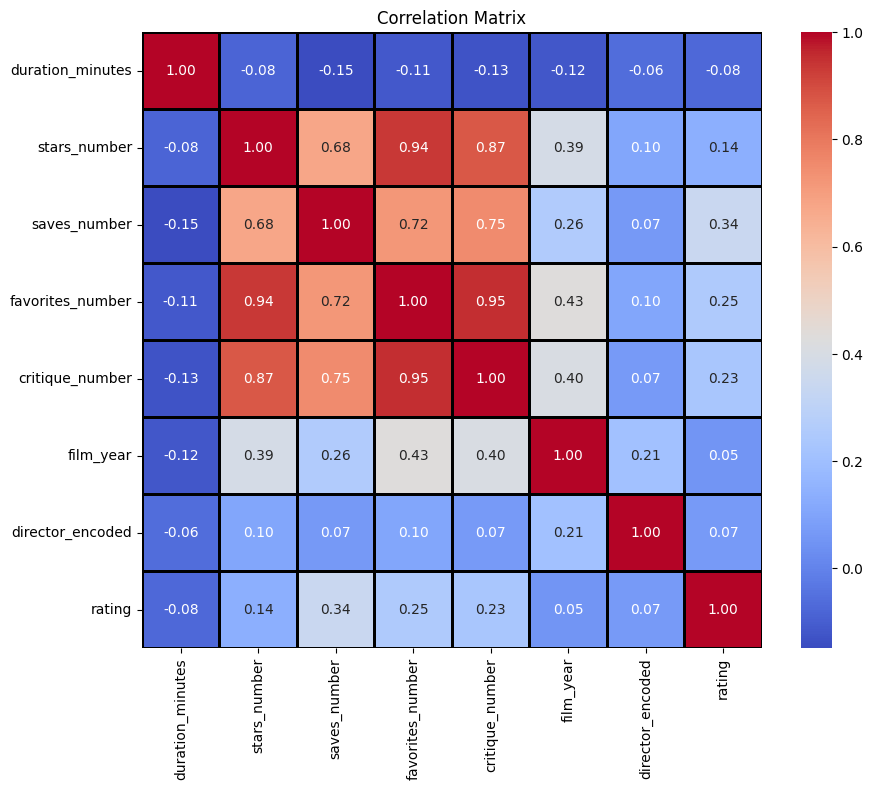

In [41]:
# chose the labled df to do correlelation matrix, as one-hot coding df has lots of columns  
combined_df = pd.concat([feature_director_final_df, rating_df], axis=1)

correlation_matrix = combined_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=2, linecolor='black')
plt.title('Correlation Matrix')
plt.show()


The correlation coefficient I've observed from the matrix is generally low. And the relationship between director and rating is also very low. 

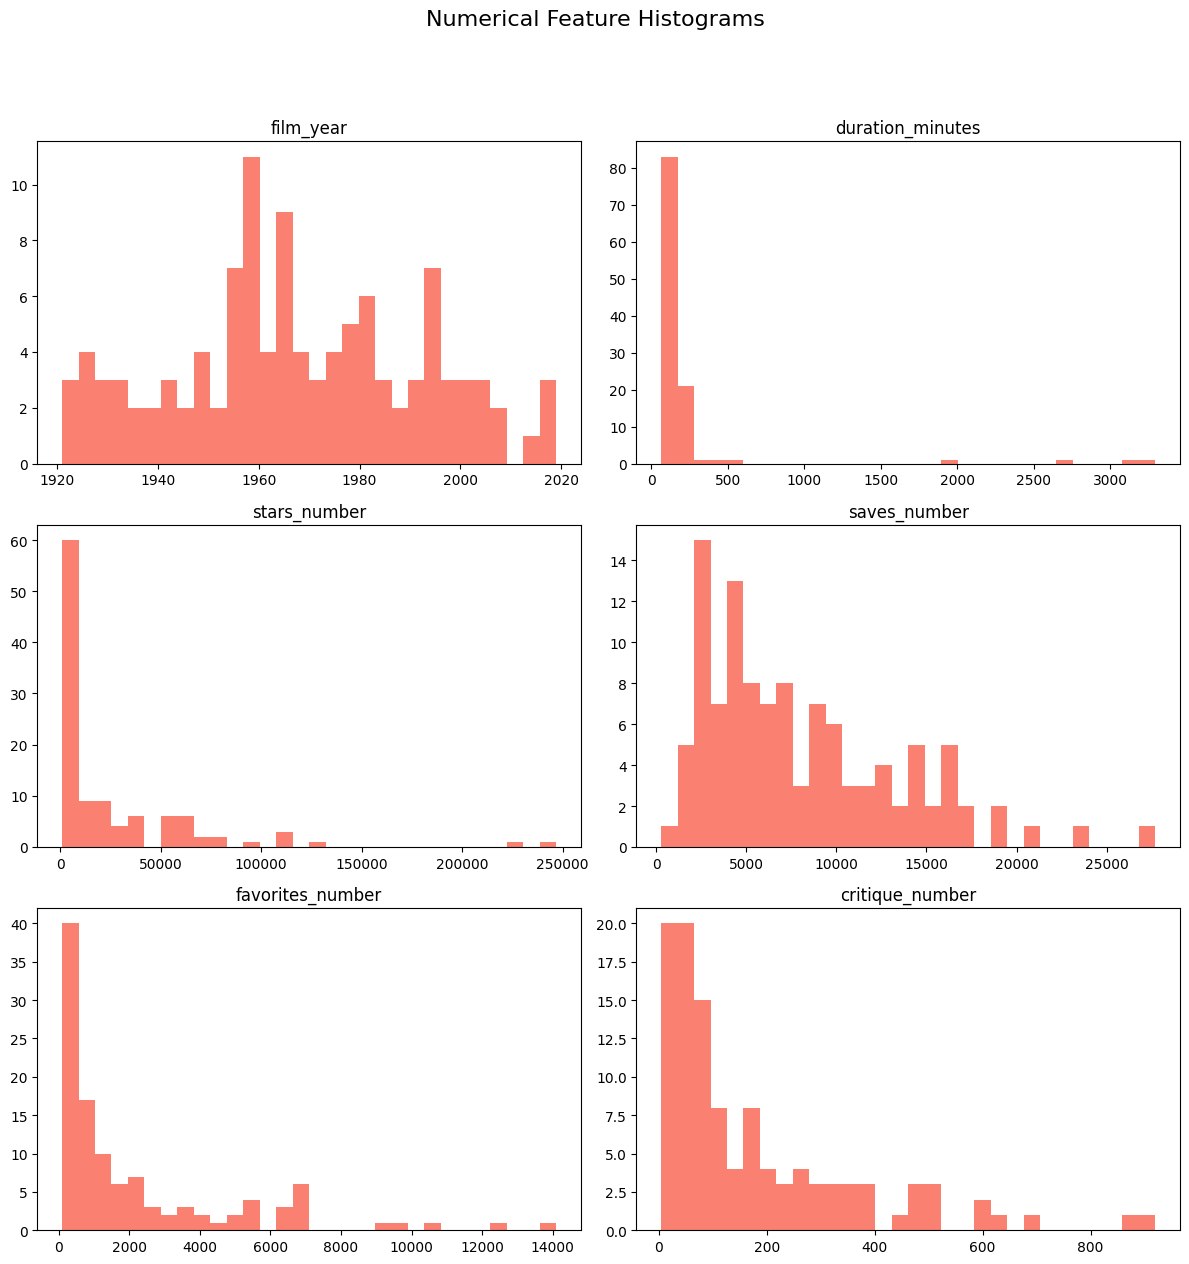

In [42]:

plt.rcParams['figure.figsize'] = 12, 12

fig, axs = plt.subplots(3, 2)
fig.suptitle('Numerical Feature Histograms', y=1.05, fontsize=16)

axs[0, 0].hist(features_final_df['film_year'].values, bins=30, color='salmon')
axs[0, 0].set_title('film_year')

axs[0, 1].hist(features_final_df['duration_minutes'].values, bins=30, color='salmon')
axs[0, 1].set_title('duration_minutes')

axs[1, 0].hist(features_final_df['stars_number'].values, bins=30, color='salmon')
axs[1, 0].set_title('stars_number')

axs[1, 1].hist(features_final_df['saves_number'].values, bins=30, color='salmon')
axs[1, 1].set_title('saves_number')

axs[2, 0].hist(features_final_df['favorites_number'].values, bins=30, color='salmon')
axs[2, 0].set_title('favorites_number')

axs[2, 1].hist(features_final_df['critique_number'].values, bins=30, color='salmon')
axs[2, 1].set_title('critique_number')

plt.tight_layout()
plt.show()

Except for `film_year`, other plots seem to be skewed distribution. So I choose to use `log` .

In [43]:
features_final_df['log_duration_minutes'] = np.log1p(features_final_df['duration_minutes'])
features_final_df['log_stars_number'] = np.log1p(features_final_df['stars_number'])
features_final_df['log_favorites_number'] = np.log1p(features_final_df['favorites_number'])
features_final_df['log_saves_number'] = np.log1p(features_final_df['saves_number'])
features_final_df['log_critique_number'] = np.log1p(features_final_df['critique_number'])


scaler = StandardScaler()

features_final_df[['log_duration_minutes', 'log_stars_number', 'log_favorites_number', 'log_saves_number', 'log_critique_number']] = scaler.fit_transform(
    features_final_df[['log_duration_minutes', 'log_stars_number', 'log_favorites_number', 'log_saves_number','log_critique_number']]
)


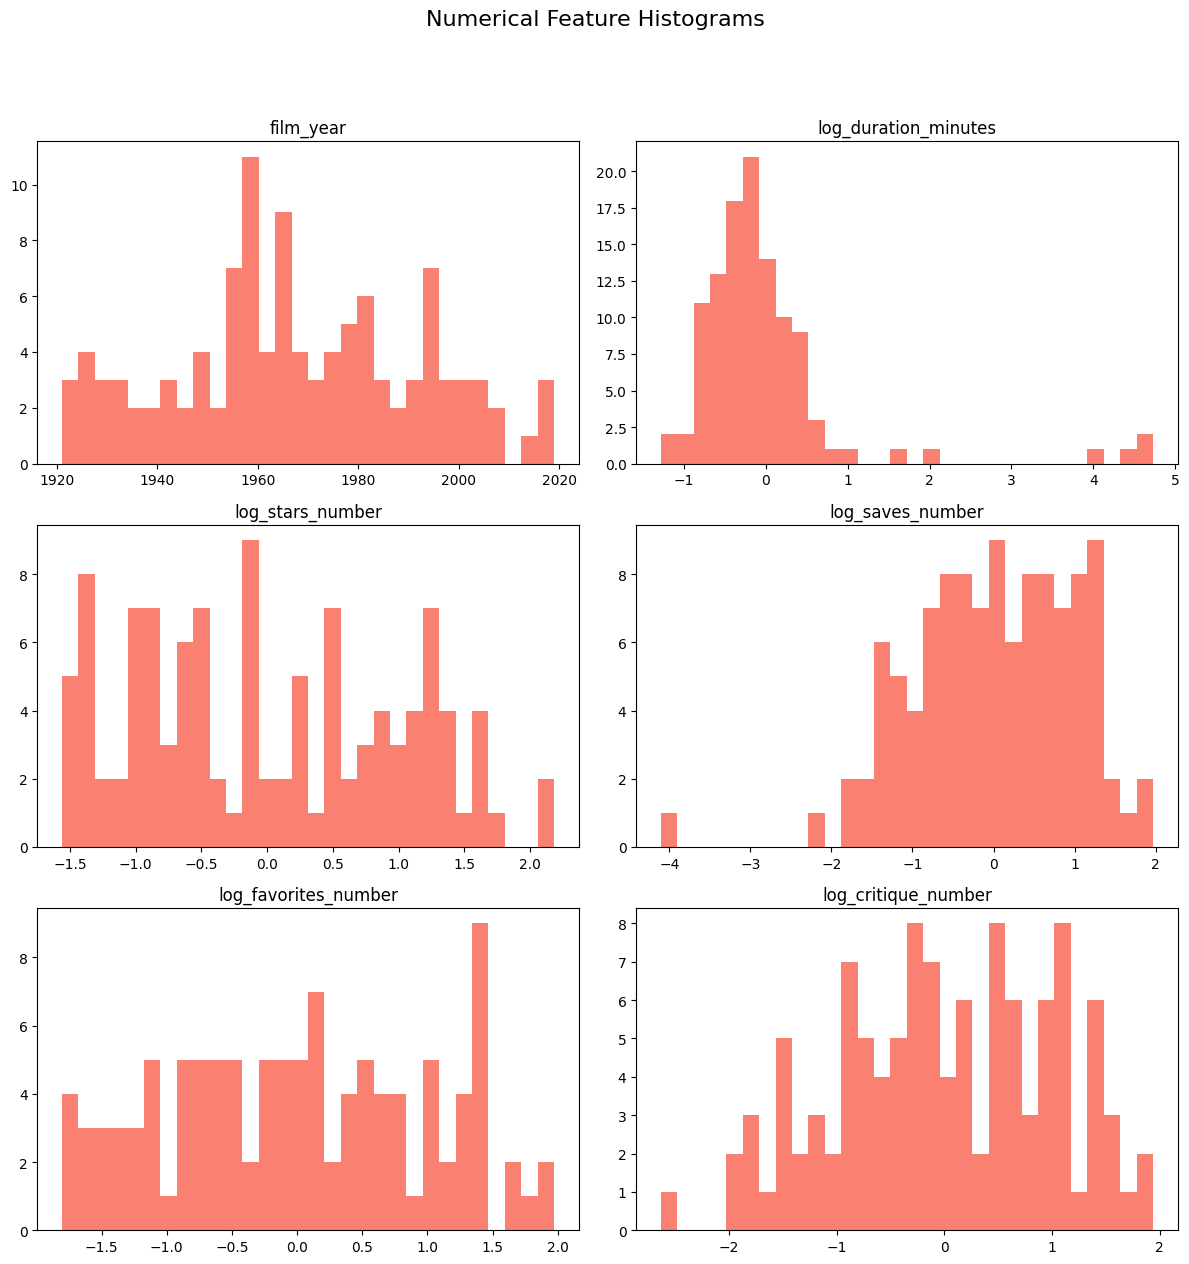

In [44]:
plt.rcParams['figure.figsize'] = 12, 12

fig, axs = plt.subplots(3, 2)
fig.suptitle('Numerical Feature Histograms', y=1.05, fontsize=16)

axs[0, 0].hist(features_final_df['film_year'].values, bins=30, color='salmon')
axs[0, 0].set_title('film_year')

axs[0, 1].hist(features_final_df['log_duration_minutes'].values, bins=30, color='salmon')
axs[0, 1].set_title('log_duration_minutes')

axs[1, 0].hist(features_final_df['log_stars_number'].values, bins=30, color='salmon')
axs[1, 0].set_title('log_stars_number')

axs[1, 1].hist(features_final_df['log_saves_number'].values, bins=30, color='salmon')
axs[1, 1].set_title('log_saves_number')

axs[2, 0].hist(features_final_df['log_favorites_number'].values, bins=30, color='salmon')
axs[2, 0].set_title('log_favorites_number')

axs[2, 1].hist(features_final_df['log_critique_number'].values, bins=30, color='salmon')
axs[2, 1].set_title('log_critique_number')

plt.tight_layout()
plt.show()

In [45]:
features_log_df = features_final_df.copy()

features_log_df.drop(columns=['duration_minutes','stars_number','saves_number','favorites_number','critique_number'],inplace=True)

In [46]:
features_log_df.head()

,film_year,director_encoded,Action,Animation,Arts martiaux,Aventure,Biopic,Cinéma,Comédie,Comédie dramatique,...,Sport,Thriller,Western,empty,Épouvante-Horreur,log_duration_minutes,log_stars_number,log_favorites_number,log_saves_number,log_critique_number
0,1997,68,False,False,False,False,False,False,False,False,...,False,False,False,False,False,-0.369852,-1.012212,-1.803748,-1.310584,-1.793202
1,1979,57,False,False,False,False,False,False,False,False,...,False,False,False,False,True,-0.369852,1.287713,1.264461,0.154915,1.435102
2,1966,3,False,False,False,False,True,False,False,False,...,False,False,False,False,False,0.310471,-0.520173,-0.458555,0.036908,-0.271224
3,1979,23,False,False,False,False,False,False,False,False,...,False,False,False,False,False,-0.022949,1.193346,1.162380,1.595436,1.158300
4,1959,52,False,False,False,False,False,False,False,False,...,False,True,False,False,False,0.105982,-0.586553,-0.682958,-0.456490,-0.259477


In [47]:
features_log_df.to_json('data/film_features.json', orient='records', lines=True)
rating_df.to_json('data/film_rating.json', orient='records', lines=True)


In [48]:
X_train, X_test, y_train, y_test = train_test_split(features_log_df, rating_df, test_size=0.2, random_state = 42)

I've tried using rating and ranking as the target df to train the machine learning model sepereately, and I found that it's easier to use `rating` as the target number.

In [49]:
X_train.head()

,film_year,director_encoded,Action,Animation,Arts martiaux,Aventure,Biopic,Cinéma,Comédie,Comédie dramatique,...,Sport,Thriller,Western,empty,Épouvante-Horreur,log_duration_minutes,log_stars_number,log_favorites_number,log_saves_number,log_critique_number
26,1942,21,False,False,False,False,False,False,True,False,...,False,False,False,False,False,-0.623320,-0.118125,-0.013502,-0.262086,-0.170779
22,1942,56,False,False,False,False,True,False,False,False,...,True,False,False,False,False,-0.548603,-1.408554,-1.133006,-1.494573,-0.877828
31,1980,34,True,False,False,True,False,False,False,False,...,False,False,False,False,False,-0.281599,1.428892,1.250701,-0.960772,1.029150
47,1928,10,False,False,False,False,False,False,False,False,...,False,False,False,False,False,-0.608082,-0.641096,-0.772212,-0.757810,-0.631998
76,1931,27,False,False,False,False,False,False,False,False,...,False,True,False,False,False,-0.369852,0.531439,0.338724,0.773865,0.446307


The reasons why I chose the Random Forest Regressor and Gradient Boosting Regressor (XGBoost) are as follows:

1. As they are **regression models**, they are more appropriate for predicting a continuous outcome, such as ratings.
2. They are **more complex **compared to Linear Regression, making them better suited to handle the features present in this dataset, like one-hot encoded features.


Here, I use Grid Search to do hyperparameter tuning.


In [50]:
# follow the dont repeat yourself principle
# using grid search to iterate the parameters
def grid_search(model, params_dict):
  search = GridSearchCV(model, params_dict, cv=5, scoring='neg_mean_squared_error')
  search.fit(X_train, y_train)
  
  return search.best_estimator_, search.best_score_

In [51]:
# random forest prediction

# create a predicting model using random forest
random_forest_movie_prediction = RandomForestRegressor()

# find out params that the model has
random_forest_movie_prediction.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [52]:
# xgboost forest prediction

# create a predicting model using xgboost
xgboost_movie_prediction = xgb.XGBRegressor()

# get params
xgboost_movie_prediction.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

Choose some commonly used params for grid search:

In [53]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10,]
}

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 4]
}

In [54]:
rf_best_estimator, rf_best_score = grid_search(random_forest_movie_prediction, param_grid_rf)
xgb_best_estimator, xgb_best_score = grid_search(xgboost_movie_prediction, param_grid_xgb)

In [55]:
print(f"Using Random Forest, the lowest negative mean squared error we could get is: {abs(rf_best_score)} and the best parameters are {rf_best_estimator.get_params()}")
print(f"Using XGBoost, the lowest negative mean squared error we could get is: {abs(xgb_best_score)} and the best parameters are {xgb_best_estimator.get_params()}")


Using Random Forest, the lowest negative mean squared error we could get is: 0.024530832406093377 and the best parameters are {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Using XGBoost, the lowest negative mean squared error we could get is: 0.028698136512117344 and the best parameters are {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': No

## 4. Key Takeaways

1. Reviewing online projects related to this subject matter is beneficial. They help me to gain insights into selecting relevant features, appropriate prediction models, and effective data cleaning methods.
2. For specific technical issues, resources like Stack Overflow can be invaluable. During a particular challenge with debugging the web driver, despite browsing official documentation and seeking assistance from ChatGPT, the solution ultimately pertained to network connectivity rather than the code itself.
3. Coding Insights:
   1. To handle different data types with a single function, consider using `isinstance` or using a parameter like `is_url=True` to adapt the function's processing logic.
   2. In web scraping, it's crucial to account for potential `None` values. This can be managed gracefully in the return statement, for example: `return found_element.text if found_element else None`.
   3. The `soup.find` method is versatile and can be applied to a range of scenarios, including searching by attributes, text content, or using regular expressions.
   4. When manipulating dataframes:
      1. To extract the initial segment of a split string, use `.str.split('.').str.get(0)`.
      2. Exercise caution with numerical values when using `groupby`.
      3. The label dataframe should always match the feature dataframe in length, indicating that simply dropping missing values (`dropna`) may not always be appropriate.